# Spam como tarea de clasificación (spam vs ham)

### Datos
* [SMS Spam Collection](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)

### Referencias
* [Natural Language Processing in Action](https://www.manning.com/books/natural-language-processing-in-action)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rchicangana/icesi_nlp/blob/main/Session%201/Taller%201/7-SpamClasificationNLTK.ipynb)

### 1. Configuración inicial
Importamos librerías básicas y suprimimos warnings para que la salida sea más legible.

### 2. Instalación de dependencias
Instalamos las librerías del proyecto desde `requirements.txt` (pandas, scikit-learn, NLTK, etc.). En entornos locales suele no ser necesario si ya están instaladas.

In [1]:
import warnings
import sys

warnings.filterwarnings('ignore')

IN_COLAB = 'google.colab' in sys.modules


In [2]:
import os

if IN_COLAB:
    # Los requerimientos se instalan en el entorno
    if not os.path.exists('requirements.txt'):
        !wget https://raw.githubusercontent.com/rchicangana/icesi_nlp/main/Session%201/Taller%201/requirements.txt
    !pip install -r requirements.txt
else:
    # En local, mantenemos en la raíz
    if not os.path.exists('requirements.txt'):
        !wget https://github.com/rchicangana/icesi_nlp/tree/main/Session%201/Taller%201/requirements.txt
    %pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import requests
import zipfile
import io

URL = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

data_dir = Path("data")
zip_path = data_dir / "sms_spam_collection.zip"
extract_dir = data_dir / "sms_spam_collection"

data_dir.mkdir(exist_ok=True)

# 1. Descargar solo si no existe
if not zip_path.exists():
    print("Descargando dataset...")
    r = requests.get(URL, timeout=60)
    r.raise_for_status()
    zip_path.write_bytes(r.content)
    print("Descarga completa.")
else:
    print("El ZIP ya existe, no se descarga.")

# 2. Extraer solo si no está extraído
if not extract_dir.exists():
    print("Extrayendo archivos...")
    extract_dir.mkdir()
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    print("Extracción completa.")
else:
    print("Los archivos ya están extraídos.")

print("Contenido:", list(extract_dir.iterdir()))

El ZIP ya existe, no se descarga.
Los archivos ya están extraídos.
Contenido: [WindowsPath('data/sms_spam_collection/readme'), WindowsPath('data/sms_spam_collection/SMSSpamCollection')]


### 3. Distribución de clases
Visualizamos el desbalance entre **ham** y **spam**. El dataset tiene muchos más mensajes legítimos (ham) que spam; esto puede afectar al entrenamiento y a las métricas.

### Carga del dataset
Cargamos el **SMS Spam Collection** (TSV con columnas `label` y `text`). El objetivo es **clasificación binaria**: spam vs ham (no análisis de sentimiento). El dataset está desbalanceado: muchos más ham (~4825) que spam (~747). No es el objetivo de este trabajo hacer fine tunning de la regresion logistica sino evidenciar el uso de NLTK para diferentes objetivos

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/sms_spam_collection/SMSSpamCollection', sep='\t', header=None, names=['label', 'text'])
df.head()
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

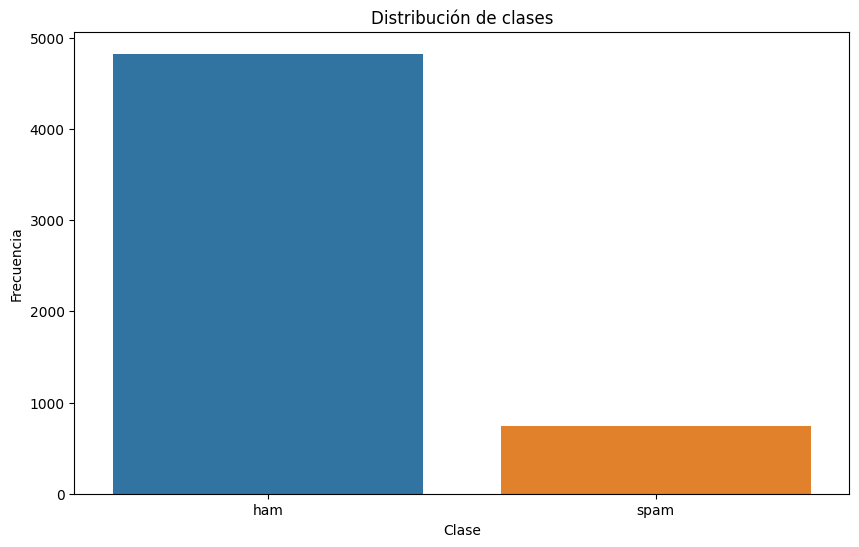

In [5]:
#MOSTRMOS LA DISTRIBUCION DE LAS CLASES EN UN  GRAFICO DE BARRAS
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


### 4. Descarga de recursos NLTK
NLTK requiere descargar datos (tokenizadores, stopwords, léxico VADER, etc.) la primera vez. `punkt` y `punkt_tab` son necesarios para `word_tokenize`.

In [6]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rchic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]    

True

### Limpieza de datos
Eliminamos filas con valores nulos o con texto vacío, y normalizamos las etiquetas a minúsculas (`spam` / `ham`) para consistencia.

In [7]:
df.dropna(inplace=True)
df['text'] = df['text'].astype(str).str.strip()
df = df[df['text'] != '']
df['label'] = df['label'].str.lower().str.strip()
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

### 5. Tokenización y longitud
Dividimos cada mensaje en **tokens** (palabras) con `word_tokenize` y calculamos **longitud** del mensaje en tokens y en caracteres. Estas serán nuestras primeras features.

In [8]:
from nltk.tokenize import word_tokenize

df['tokens'] = df['text'].apply(word_tokenize)
df['num_tokens'] = df['tokens'].apply(len)
df['num_chars'] = df['text'].apply(len)

### 6. Proporción de stopwords
Contamos cuántas palabras de cada mensaje son **stopwords** (the, is, at, …) y la proporción respecto al total. Los mensajes muy “limpios” pueden comportarse distinto a los que repiten palabras comunes.

In [9]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
df['num_stopwords'] = df['tokens'].apply(lambda t: sum(1 for w in t if w.lower() in stop))
df['pct_stopwords'] = df['num_stopwords'] / df['num_tokens'].replace(0, 1)

### 7. Palabras frecuentes por clase (FreqDist)
Obtenemos las **100 palabras más frecuentes** en spam y en ham con `FreqDist`. Para cada mensaje contamos cuántas de esas palabras aparecen (`count_top_spam`, `count_top_ham`). Así el modelo puede usar “vocabulario típico” de cada clase.

**Palabras típicas por clase**  
Usamos las palabras más frecuentes en spam y en ham como referencia; para cada mensaje contamos cuántas de esas palabras aparecen (features `count_top_spam`, `count_top_ham`). Ver siguiente celda.

In [10]:
from nltk import FreqDist

spam_tokens = df[df['label'] == 'spam']['tokens'].explode()
ham_tokens = df[df['label'] == 'ham']['tokens'].explode()
freq_spam = FreqDist(spam_tokens)
freq_ham = FreqDist(ham_tokens)

top_spam_words = set(w for w, _ in freq_spam.most_common(100))
top_ham_words = set(w for w, _ in freq_ham.most_common(100))

def count_in_set(tokens, s):
    return sum(1 for t in tokens if t.lower() in s)

df['count_top_spam'] = df['tokens'].apply(lambda t: count_in_set(t, top_spam_words))
df['count_top_ham'] = df['tokens'].apply(lambda t: count_in_set(t, top_ham_words))

**Bigramas frecuentes (spam vs ham)**  
Usamos `BigramCollocationFinder` para obtener los pares de palabras más frecuentes en spam y en ham; luego contamos cuántos de esos bigramas aparecen en cada mensaje (features `count_top_spam_bigrams` y `count_top_ham_bigrams`).

In [11]:
from nltk.collocations import BigramCollocationFinder
from nltk import bigrams

# Tokens de todos los mensajes spam y ham (listas planas)
spam_all_tokens = [t for tokens in df[df['label'] == 'spam']['tokens'] for t in tokens]
ham_all_tokens = [t for tokens in df[df['label'] == 'ham']['tokens'] for t in tokens]

# Bigramas más frecuentes por clase (top 100)
finder_spam = BigramCollocationFinder.from_words(spam_all_tokens)
finder_ham = BigramCollocationFinder.from_words(ham_all_tokens)
top_spam_bigrams = set(b for b, _ in finder_spam.ngram_fd.most_common(100))
top_ham_bigrams = set(b for b, _ in finder_ham.ngram_fd.most_common(100))

# Normalizar a minúsculas para comparar
top_spam_bigrams_lower = set((a.lower(), b.lower()) for a, b in top_spam_bigrams)
top_ham_bigrams_lower = set((a.lower(), b.lower()) for a, b in top_ham_bigrams)

def count_bigrams_in_set(tokens, bigram_set):
    msg_bigrams = list(bigrams(tokens))
    return sum(1 for (a, b) in msg_bigrams if (a.lower(), b.lower()) in bigram_set)

df['count_top_spam_bigrams'] = df['tokens'].apply(lambda t: count_bigrams_in_set(t, top_spam_bigrams_lower))
df['count_top_ham_bigrams'] = df['tokens'].apply(lambda t: count_bigrams_in_set(t, top_ham_bigrams_lower))

# Opcional: ver algunos bigramas típicos de spam
print("Ejemplo de bigramas frecuentes en spam:", list(top_spam_bigrams)[:10])
print("Ejemplo de bigramas frecuentes en ham:", list(top_ham_bigrams)[:10])

Ejemplo de bigramas frecuentes en spam: [('.', 'Your'), ('Valid', '12hrs'), ('or', 'call'), ('are', 'trying'), ('line', '.'), ('PO', 'Box'), ('have', 'been'), ('with', 'a'), ('.', 'Text'), ('PRIVATE', '!')]
Ejemplo de bigramas frecuentes en ham: [('I', 'love'), ('.', 'How'), ('.', 'But'), ('are', 'you'), ('you', '?'), ('you', '.'), ('in', 'a'), ('Have', 'a'), ('.', 'I'), ('going', 'to')]


### 8. Puntuación y mayúsculas
El spam suele usar más **mayúsculas** y **signos de puntuación** (¡ofertas!, URGENT!!!). Calculamos número y proporción de mayúsculas y de caracteres de puntuación por mensaje como features adicionales.

In [12]:
import string

df['num_uppercase'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['pct_uppercase'] = df['num_uppercase'] / df['num_chars'].replace(0, 1)
df['num_punctuation'] = df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

### 9. Puntuaciones VADER (sentimiento)
Usamos **VADER** de NLTK para obtener scores de sentimiento (neg, neu, pos, compound) de cada mensaje. No clasificamos por sentimiento; usamos estos valores como **features** para el clasificador spam/ham.

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
scores = df['text'].apply(sid.polarity_scores)
df['vader_neg'] = scores.apply(lambda s: s['neg'])
df['vader_neu'] = scores.apply(lambda s: s['neu'])
df['vader_pos'] = scores.apply(lambda s: s['pos'])
df['vader_compound'] = scores.apply(lambda s: s['compound'])

### 10. Matriz de features y entrenamiento
Se construye **X** con todas las features (tokenización, stopwords, FreqDist, bigramas, mayúsculas, puntuación, VADER). Se divide en train/test, se escala con StandardScaler y se entrena una regresión logística.

In [14]:
feature_cols = [
    'num_tokens', 'num_chars', 'pct_stopwords',
    'count_top_spam', 'count_top_ham',
    'num_uppercase', 'pct_uppercase', 'num_punctuation',
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'count_top_spam_bigrams',
    'count_top_ham_bigrams'
]

X = df[feature_cols].copy()
# Rellenar NaN por si acaso
X = X.fillna(0)
y = df['label'].copy()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))



Accuracy: 0.9691313711414213

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1206
        spam       0.92      0.84      0.88       187

    accuracy                           0.97      1393
   macro avg       0.95      0.92      0.93      1393
weighted avg       0.97      0.97      0.97      1393

Confusion Matrix:
 [[1192   14]
 [  29  158]]


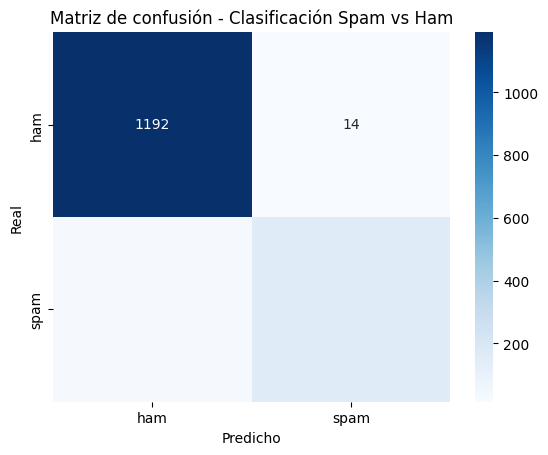

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión - Clasificación Spam vs Ham')
plt.show()

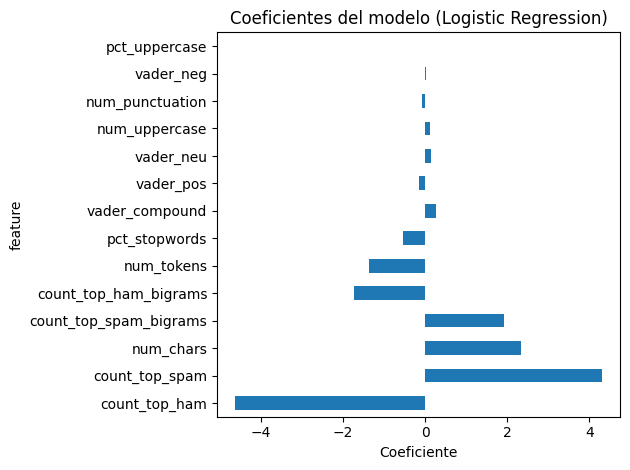

In [17]:
coef = pd.DataFrame({'feature': feature_cols, 'coef': clf.coef_[0]})
coef = coef.reindex(coef.coef.abs().sort_values(ascending=False).index)
coef.plot(x='feature', y='coef', kind='barh', legend=False)
plt.title('Coeficientes del modelo (Logistic Regression)')
plt.xlabel('Coeficiente')
plt.tight_layout()
plt.show()

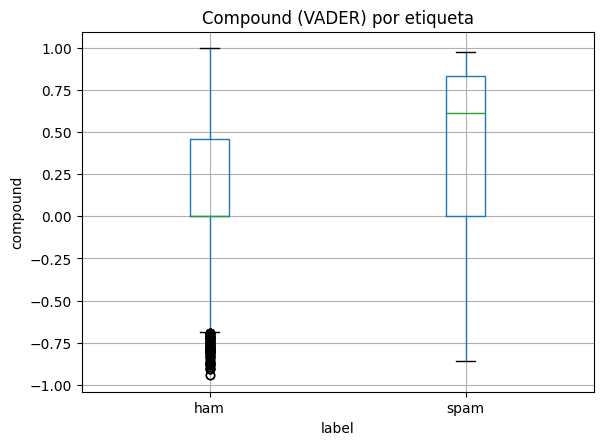

In [18]:
df.boxplot(column='vader_compound', by='label')
plt.suptitle('')
plt.title('Compound (VADER) por etiqueta')
plt.ylabel('compound')
plt.show()

## Conclusiones

### Objetivo
Se abordó la **clasificación binaria spam vs ham** sobre el SMS Spam Collection usando **NLTK** para el procesamiento y la extracción de features de texto, y **scikit-learn** para el modelo.

### Importancia del uso de NLTK en este trabajo

NLTK fue la base del **preprocesamiento y de la ingeniería de features**; sin ella el clasificador solo dispondría del texto crudo y tendría un rendimiento muy inferior.

1. **Tokenización (`word_tokenize`, `punkt` / `punkt_tab`)**  
   Permitió pasar de cadenas de texto a listas de palabras de forma consistente (manejo de puntuación, contracciones, etc.). A partir de ahí se obtuvieron **longitud en tokens**, **conteo de stopwords** y la entrada para FreqDist y bigramas. Sin tokenización adecuada, las estadísticas por mensaje no serían fiables.

2. **Stopwords (`nltk.corpus.stopwords`)**  
   La proporción de stopwords por mensaje aporta una feature de “estilo”: el spam suele repetir palabras llamativas (free, win, click) y puede tener una proporción distinta de palabras funcionales (the, is, to) respecto al ham. NLTK proporciona la lista estándar en inglés para calcular esta feature de forma directa.

3. **Frecuencia de palabras (`FreqDist`)**  
   Se usó para obtener las palabras más frecuentes en spam y en ham por separado. Eso permitió definir features como **count_top_spam** y **count_top_ham**: cuántas de esas palabras típicas aparecen en cada mensaje. Así el modelo puede usar “vocabulario característico” de cada clase; sin NLTK habría que implementar a mano el conteo y la selección de términos.

4. **Bigramas (`BigramCollocationFinder`, `bigrams`)**  
   Los pares de palabras (bigramas) capturan contexto que las palabras sueltas no dan (por ejemplo “free prize” vs “free” y “prize” por separado). Con **BigramCollocationFinder** se obtuvieron los bigramas más frecuentes por clase y se contó cuántos aparecen en cada mensaje. Eso añade señal útil para distinguir spam de ham y es una funcionalidad que NLTK expone de forma sencilla.

5. **Sentimiento (VADER, `nltk.sentiment.vader`)**  
   Aunque la tarea no es análisis de sentimiento, las puntuaciones VADER (neg, neu, pos, compound) se usaron como **features numéricas** para el clasificador. El spam suele usar un lenguaje más “urgente” o promocional, y VADER captura parte de ese perfil. NLTK incluye el léxico y la interfaz listos para usar.

En conjunto, NLTK permitió **tokenizar, medir estilo (stopwords), usar vocabulario y bigramas por clase, y añadir señales de sentimiento** sin implementar desde cero ni depender solo del texto crudo. El buen rendimiento del modelo (p. ej. ~97 % accuracy) refleja que estas features derivadas con NLTK aportan información discriminativa para la tarea.

### Pipeline resumido
- Datos: SMS Spam Collection; limpieza y normalización de etiquetas.
- Features: tokenización y longitud, stopwords, FreqDist (palabras), BigramCollocationFinder (bigramas), mayúsculas/puntuación, VADER.
- Modelo: regresión logística con StandardScaler; train/test estratificado.

### Resultados y hallazgos
El modelo alcanzó un accuracy alto en test; la matriz de confusión muestra pocos falsos positivos y falsos negativos. Las features basadas en NLTK (palabras y bigramas por clase, proporción de stopwords, VADER) resultaron útiles; las heurísticas de formato (mayúsculas, puntuación) complementan la señal léxica.

### Limitaciones
- Dataset desbalanceado (más ham que spam).
- Corpus en inglés; no directamente transferible a español sin adaptar recursos NLTK.
- Features manuales; no se usan embeddings ni modelos de lenguaje.

### Posibles mejoras
- Balanceo de clases o pesos en el clasificador.
- Añadir TF-IDF o bolsa de palabras sobre los tokens.
- Ajustar umbral o calibración para priorizar recall en spam si el costo de los falsos negativos es alto.